# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Structure 

* [Problem Statement](#Problem-Statement)
* [Metrics](#Metrics)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    * [Check which received offers have been completed](#Check-which-received-offers-have-been-completed)
    * [Manual cross check if values are right](#Manual-cross-check-if-values-are-right)
* [Data Cleaning: clean profile](#Data-Cleaning:-clean-profile)
* Further Analysis
    * [Analyze reponses over groups](#Analyze-reponses-over-groups)
    * [Analyze the membership duration in days](#Analyze-the-membership-duration-in-days)
    * [Control Metrics](#Control-Metrics)
    * [How many transaction have been done by an user?](#How-many-transaction-have-been-done-by-an-user?)
    * [Are informational offers completable?](#Are-informational-offers-completable?)
    * [Is there a group which is highly responding to informational offers?](#Is-there-a-group-which-is-highly-responding-to-informational-offers?)
    * [Which one has a higher response rage? BOGO or Discount? Differences in gender?](#Which-one-has-a-higher-response-rage?-BOGO-or-Discount?-Differences-in-gender?)
    * [Histograms, Means and Standard Deviations](#Histograms,-Means-and-Standard-Deviations)
    * [Which channel for which user?](#Which-channel-for-which-user?)
    * [Which group responds to informational offers](#Which-group-responds-to-informational-offers)
    * [Combine: Which offer for which group?](#Combine:-Which-offer-for-which-group?)
* [Which channel should be used for which offer type](#)
* [Predict: Can we predict the offer type with the highest response rate of a user?](#Predict:-Can-we-predict-the-offer-type-with-the-highest-response-rate-of-a-user?)
* [Conclusion](#Conclusion)
* [Further work](#Further-work)

The nature of notebooks is a lengthy one. In case you want a quick go-trough and only have a look at the essentials, try these:
* [Problem Statement](#Problem-Statement)
* [Metrics](#Metrics)
* [Combine: Which offer for which group?](#Combine:-Which-offer-for-which-group?)
* [Conclusion](#Conclusion)
* [Further work](#Further-work)

### Problem Statement
The available data shows the behaviour people to offers and discounts. As marketing activities like this are a cost factor, groups of people should be identified, for which this activities are most likely successful.
To do so, the percentage of positive responses to an offer should be evaluated for groups of people. 
The grouping can be done by age, income, membership duration and/or gender.
In addition we would like to limit frustration by sending the wrong offers.

We are interested in the follwing questions.

#### Which channel should be used for which offer type?
Identify a channel with the highest response rate for each offer type. This could extend a possible recommendation system.

#### Can we predict the offer type with the highest response rate of a user?
Predict the offer type with the highest response rate for a user. Such a model would be a good recommendation system.

### Metrics
#### Response rate
As metric for the performance of each group, we use the ratio of successful responses of offers.

A successful response ...
* ... is the completion of an offer or a transaction after receiving a informational offer.
* ... have to take place within the given `duration`-time frame.
* ... is only given, if the offer has been viewed in the `duration`-time frame.


#### F1 score (classification)
The performance of classification models is evaluated regarding the F1-score:

${\displaystyle F_{1}=\left({\frac {2}{\mathrm {recall} ^{-1}+\mathrm {precision} ^{-1}}}\right)=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}}$

It's simply the harmonic mean of precision and recall. Both are important for our model, especially in this case, as there is a class imbalance. Measuring just with accuracy would not take recall and precision into consideration. 

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory Data Analysis

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


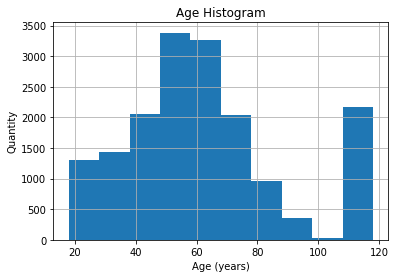

In [6]:
profile["age"].hist()
plt.xlabel("Age (years)")
plt.ylabel("Quantity")
plt.title("Age Histogram");

> Weird distribution and high mean. Above 110 might be deniers.

In [7]:
profile["age"].where(lambda x: x > 110).mean()

118.0

In [8]:
profile["age"].where(lambda x: x == 118).count(), profile.shape[0]

(2175, 17000)

> Over 10% are 118 years old? Is this a kind of a standard value?

In [9]:
profile.where(lambda x: x["age"] == 118).describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


> None of these have income values

In [10]:
profile.where(lambda x: np.isnan(x["income"])).describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


> Exactly those values who have no income do have a suspicious high age: 118

In [11]:
profile[profile["income"].isna()]["gender"].mean()

nan

In [12]:
profile[profile["income"].notnull()]["gender"].value_counts(dropna=False)

M    8484
F    6129
O     212
Name: gender, dtype: int64

> In addition, these values have no gender information.

In [13]:
profile["income"].isna().mean()

0.12794117647058822

> But these strange values 12.79% of the profile.

In [14]:
profile[profile["income"].isna()]["gender"].mean()

nan

In [15]:
profile["gender"].value_counts(dropna=False)

M      8484
F      6129
NaN    2175
O       212
Name: gender, dtype: int64

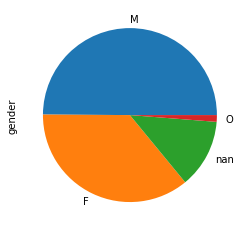

In [16]:
profile["gender"].value_counts(dropna=False).plot.pie();

In [17]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [18]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [19]:
transcript[transcript["event"] == "transaction"].head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [20]:
transcript[transcript["event"] == "offer completed"].iloc[0, :]["value"]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In [21]:
transcript[transcript["event"] == "offer viewed"].head()

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


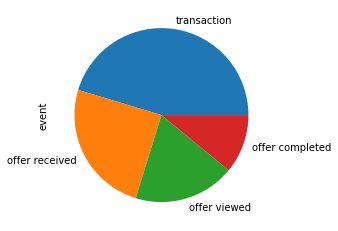

In [22]:
transcript["event"].value_counts(dropna=False).plot.pie();

In [23]:
transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

In [24]:
type(transcript.loc[0,"value"])

dict

In [25]:
(
    (transcript["event"] == "offer viewed") & 
    (transcript["person"] == "389bc3fa690240e798340f5a15918d5c") & 
    (transcript["value"] == {"offer id": "f19421c1d4aa40978ebb69ca19b0e20d"})
).sum() 

2

In [26]:
offer_received_cond = (
    (transcript["event"] == "offer received") & 
    (transcript["person"] == "389bc3fa690240e798340f5a15918d5c") & 
    (transcript["value"] == {"offer id": "f19421c1d4aa40978ebb69ca19b0e20d"})
)
offer_received_cond.sum() 

2

In [27]:
transcript[offer_received_cond]

,person,event,value,time
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
201577,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},504


> one offer can be received multiple times

#### Check which received offers have been completed

In [28]:
# "offer received" and "offer viewed" have a 'offer id', whereas "offer completed" has a 'offer_id'
transcript["offer_id"] = transcript["value"].apply(lambda x: x.get("offer id", x.get("offer_id", np.nan)))

In [29]:
# join 'received offers' with portfolio to get validity duration
offer_received = transcript[transcript["event"] == "offer received"]
offer_received.index.name = "event_id"
offer_received = offer_received[["offer_id", "time", "person"]].reset_index().merge(
    portfolio[["id", "duration"]], 
    how='inner', 
    left_on="offer_id", 
    right_on="id"
)
offer_received["max_end_time"] = offer_received[["time", "duration"]].sum(axis=1)
offer_received.head()

,event_id,offer_id,time,person,id,duration,max_end_time
0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,7
1,18,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,7
2,21,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,7
3,28,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,c0d210398dee4a0895b24444a5fcd1d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,7
4,30,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,57dd18ec5ddc46828afb81ec5977bef2,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,7


In [30]:
completed_received_transcript = transcript[transcript["event"] == "offer completed"].merge(
    offer_received,
    on=["offer_id", "person"],
    suffixes=["_completed", "_received"],
    how="right"
).set_index("event_id")
completed_received_transcript.head()

,person,event,value,time_completed,offer_id,time_received,id,duration,max_end_time
event_id,,,,,,,,,
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0.0,2906b810c7d4411798c6938adc9daaa5,0,2906b810c7d4411798c6938adc9daaa5,7,7
107,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,fafdcd668e3743c1bb461111dcafc2a4,10,10
125,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,7
35,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0.0,ae264e3637204a6fb9bb56bc8210ddfd,0,ae264e3637204a6fb9bb56bc8210ddfd,7,7
227,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,5,5


In [31]:
completion_validity_condition = (
    (completed_received_transcript["time_completed"] >= completed_received_transcript["time_received"]) &
    (completed_received_transcript["time_completed"] <= completed_received_transcript["max_end_time"]) 
)
completion_validity_condition.head()

event_id
36     True
107    True
125    True
35     True
227    True
dtype: bool

In [32]:
completed = completion_validity_condition.groupby(completion_validity_condition.index).any()

In [33]:
completed.index.duplicated().any()

False

In [34]:
completed.mean()

0.04722262280897256

In [35]:
transcript.loc[completed.index, "completed"] = completed

In [36]:
transcript["completed"].sum()

3602

#### Manual cross check if values are right

In [37]:
portfolio[portfolio["id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2"]

,reward,channels,difficulty,duration,offer_type,id
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2


In [38]:
condition = (
    (transcript["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2") & 
    (transcript["person"] == "bb0f25e23a4c4de6a645527c275cd594")
)
transcript[condition]

,person,event,value,time,offer_id,completed
317,bb0f25e23a4c4de6a645527c275cd594,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,2298d6c36e964ae4a3e7e9706d1fb8c2,True
12721,bb0f25e23a4c4de6a645527c275cd594,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
40812,bb0f25e23a4c4de6a645527c275cd594,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},96,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
245438,bb0f25e23a4c4de6a645527c275cd594,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576,2298d6c36e964ae4a3e7e9706d1fb8c2,False
262223,bb0f25e23a4c4de6a645527c275cd594,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},582,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
291555,bb0f25e23a4c4de6a645527c275cd594,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,654,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN


> Offers can be completed, even though they haven't been viewed.
> Are users aware of their unviewed offers? Presumably not

### Data Cleaning: clean profile
There are uses where age, income _and_ gender is missing. Let's call them _ghosts_.

In [39]:
ghosts_cond = ( 
    (profile["income"].isna()) & (profile["gender"].isna()) & (profile["age"] == 118)
)
ghosts_cond.sum()

2175

In [40]:
# Do they only receive informational offers?
ghost_transcript = pd.merge(
    profile[ghosts_cond], 
    transcript[transcript["event"] == "offer received"],
    left_on="id",
    right_on="person"
)
ghost_transcript_portfolio = pd.merge(
    ghost_transcript,
    portfolio,
    left_on="offer_id",
    right_on="id"
)

In [41]:
ghost_transcript_portfolio.describe()

,age,became_member_on,income,time,reward,difficulty,duration
count,9776.0,9.776000e+03,0.0,9776.000000,9776.000000,9776.000000,9776.000000
mean,118.0,2.016803e+07,NaN,332.366612,4.220540,7.663871,6.477394
std,0.0,1.018306e+04,NaN,196.233121,3.404353,5.474344,2.181836
min,118.0,2.013080e+07,NaN,0.000000,0.000000,0.000000,3.000000
25%,118.0,2.016063e+07,NaN,168.000000,2.000000,5.000000,5.000000
50%,118.0,2.017080e+07,NaN,408.000000,5.000000,7.000000,7.000000
75%,118.0,2.017123e+07,NaN,504.000000,5.000000,10.000000,7.000000
max,118.0,2.018073e+07,NaN,576.000000,10.000000,20.000000,10.000000


In [42]:
ghost_transcript_portfolio[["completed"]].sum()

completed    46.0
dtype: float64

In [43]:
ghost_transcript_portfolio["offer_type"].unique()

array(['discount', 'bogo', 'informational'], dtype=object)

There are 2175 ghost with unkown age, income and gender. Even some of them completes offers. However, as the task is to *_identify which groups of people are most responsive to each type of offer_*, these people can't be grouped.

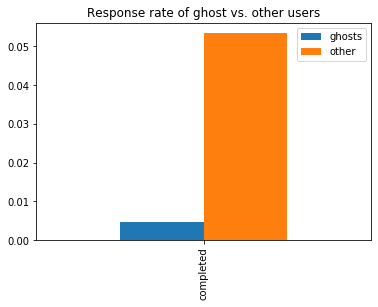

In [44]:
pd.DataFrame([ghost_transcript[["completed"]].mean(), pd.merge(
    profile[~ghosts_cond], 
    transcript[transcript["event"] == "offer received"],
    left_on="id",
    right_on="person"
)[["completed"]].mean()], index=["ghosts", "other"]).T.plot.bar();
plt.title("Response rate of ghost vs. other users");

In addition, these _"ghosts"_ seems to view the offers more often, but it's much less likely for those to complete the offers. For the further consideration they are ignored.

In [45]:
profile = profile[~ghosts_cond]

### Analyze reponses over groups

In [46]:
# check which offers have actually been viewed
offer_received = transcript[transcript["event"] == "offer received"]
offer_received.index.name = "event_id"
offer_received = offer_received.reset_index().merge(
    portfolio, 
    left_on="offer_id", 
    right_on="id"
)
offer_received["max_end_time"] = offer_received[["time", "duration"]].sum(axis=1)

# joining "offer received" and "offer viewed" to check them afterwards
viewed_received_transcript = offer_received.merge(
    transcript[transcript["event"] == "offer viewed"],
    how="left",
    on=["offer_id", "person"],
    suffixes=["_received", "_viewed"]
)

viewed_received_transcript["viewed"] = (
    (viewed_received_transcript["time_viewed"] >= viewed_received_transcript["time_received"]) &
    (viewed_received_transcript["time_viewed"] <= viewed_received_transcript["max_end_time"]) 
)
viewed = viewed_received_transcript.groupby("event_id")["viewed"].any()
transcript.loc[viewed.index, "viewed"] = viewed

In [47]:
received = pd.merge(
    transcript[transcript["event"] == "offer received"], 
    portfolio[portfolio["offer_type"] != "informational"], 
    left_on="offer_id", 
    right_on="id", 
    how="inner"
)
received = received.merge(
    profile,
    how="inner",
    left_on="person",
    right_on="id",
    suffixes=('_offer', '_profile')
)
received["gender"].fillna("unknown", inplace=True)
received["completed"] = received[["completed", "viewed"]].all(axis=1).astype(int)

received.groupby("gender")["completed"].mean()

gender
F    0.037914
M    0.025064
O    0.061026
Name: completed, dtype: float64

In [48]:
received.head()

,person,event,value,time,offer_id,completed,viewed,reward,channels,difficulty,duration,offer_type,id_offer,gender,age,id_profile,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,True,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},504,f19421c1d4aa40978ebb69ca19b0e20d,0,False,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408,ae264e3637204a6fb9bb56bc8210ddfd,0,True,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
3,ebe7ef46ea6f4963a7dd49f501b26779,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,False,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,59,ebe7ef46ea6f4963a7dd49f501b26779,20150121,41000.0
4,ebe7ef46ea6f4963a7dd49f501b26779,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},576,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,False,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,59,ebe7ef46ea6f4963a7dd49f501b26779,20150121,41000.0


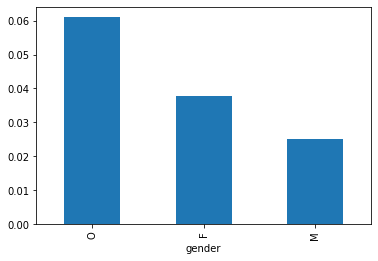

In [49]:
received.groupby("gender")["completed"].mean().sort_values(ascending=False).plot.bar();

In [50]:
received.corr()

,time,completed,reward,difficulty,duration,age,became_member_on,income
time,1.000000,0.011031,-0.000693,-0.005462,-0.005168,0.002154,0.001177,-0.001117
completed,0.011031,1.000000,-0.034019,-0.049107,0.007763,0.019287,-0.038922,0.049830
reward,-0.000693,-0.034019,1.000000,0.063028,-0.455532,-0.001330,-0.004337,0.002803
difficulty,-0.005462,-0.049107,0.063028,1.000000,0.643648,-0.000435,-0.001765,-0.001331
duration,-0.005168,0.007763,-0.455532,0.643648,1.000000,0.000901,-0.001822,-0.003093
age,0.002154,0.019287,-0.001330,-0.000435,0.000901,1.000000,-0.009134,0.305578
became_member_on,0.001177,-0.038922,-0.004337,-0.001765,-0.001822,-0.009134,1.000000,-0.025077
income,-0.001117,0.049830,0.002803,-0.001331,-0.003093,0.305578,-0.025077,1.000000


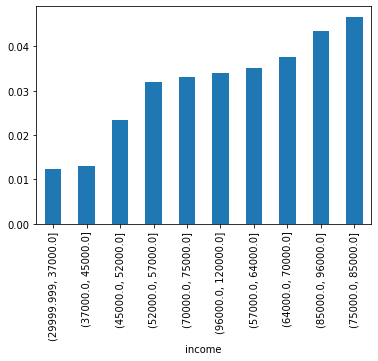

In [51]:
received.groupby(pd.qcut(received['income'], q=10))["completed"].mean().sort_values(ascending=True).plot.bar();

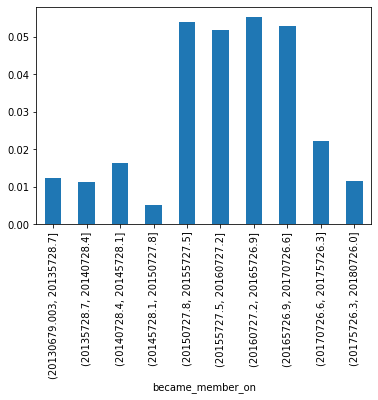

In [52]:
received.groupby(pd.cut(received['became_member_on'], bins=10))["completed"].mean().plot.bar();

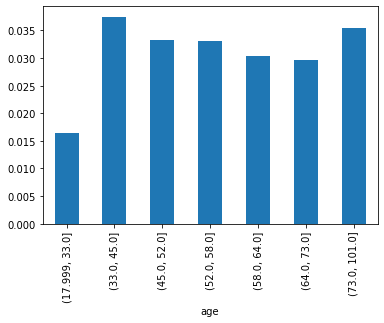

In [53]:
received.groupby(pd.qcut(received['age'], q=7))["completed"].mean().plot.bar();

#### Analyze the membership duration in days

In [54]:
became_member = pd.to_datetime(received["became_member_on"], format="%Y%m%d")
received["membership_duration"] =  became_member.max() - became_member
received["membership_duration"][:10]

0    443 days
1    443 days
2    443 days
3   1282 days
4   1282 days
5   1282 days
6   1282 days
7    747 days
8    747 days
9    747 days
Name: membership_duration, dtype: timedelta64[ns]

In [55]:
became_member = pd.to_datetime(profile["became_member_on"], format="%Y%m%d")
profile["membership_duration"] = (became_member.max() - became_member).dt.days
profile["membership_duration"][:10]

1      376
3      443
5       91
8      167
12     257
13     318
14    1624
15     896
16    1351
18     207
Name: membership_duration, dtype: int64

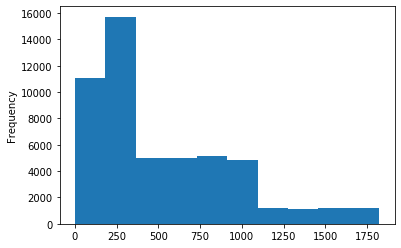

In [56]:
received[received["completed"] == False]["membership_duration"].dt.days.plot.hist();

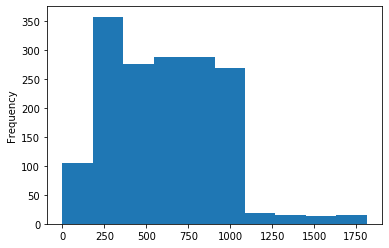

In [57]:
received[received["completed"] == True]["membership_duration"].dt.days.plot.hist();

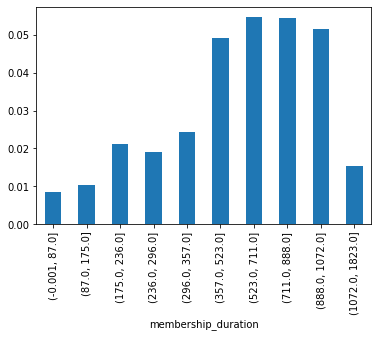

In [58]:
received.groupby(pd.qcut(received['membership_duration'].dt.days, q=10))["completed"].mean().plot.bar();

> maybe informational offers should be excluded in this calculation, as the can't be completed

### Control Metrics
Response during experiment shouldn't change, should it?

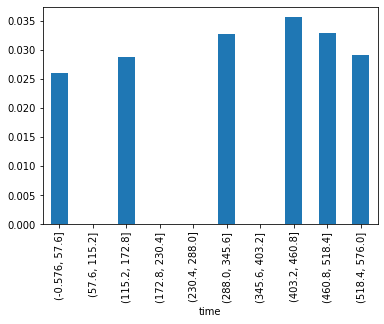

In [59]:
received.groupby(pd.cut(received['time'], bins=10))["completed"].mean().plot.bar();

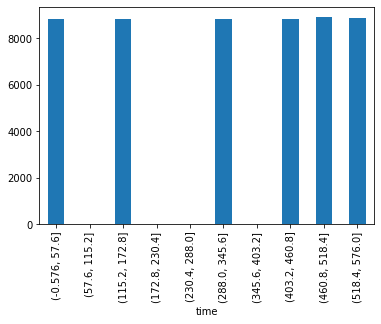

In [60]:
received.groupby(pd.cut(received['time'], bins=10))["time"].count().plot.bar();

### How many transaction have been done by an user?

In [61]:
transaction_per_user = transcript[transcript["event"] == "transaction"].merge(
    profile,
    how="outer",
    left_on="person",
    right_on="id"
).groupby("id")["person"].count()
transaction_per_user.mean()

8.361349072512647

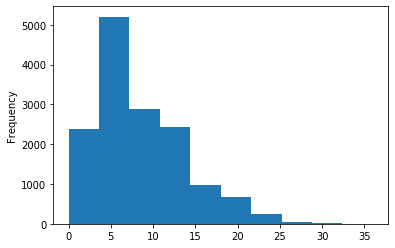

In [62]:
transaction_per_user.plot.hist();

### Are informational offers completable?

In [63]:
informational_offers = pd.merge(
    transcript[transcript["event"] == "offer received"], 
    portfolio[portfolio["offer_type"] == "informational"], 
    left_on="offer_id", 
    right_on="id", 
    how="inner"
)
informational_offers["completed"].any()

False

### Is there a group which is highly responding to informational offers?

In [64]:
informational_offers_profile = pd.merge(informational_offers, profile, left_on="person", right_on="id", how="right")
informational_offers_profile

,person,event,value,time,offer_id,completed,viewed,reward,channels,difficulty,duration,offer_type,id_x,gender,age,id_y,became_member_on,income,membership_duration
0,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0.0,3f207df678b143eea3cee63160fa8bed,False,False,0.0,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,257
1,c27e0d6ab72c455a8bb66d980963de60,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0.0,3f207df678b143eea3cee63160fa8bed,False,False,0.0,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,F,78,c27e0d6ab72c455a8bb66d980963de60,20170616,71000.0,405
2,c27e0d6ab72c455a8bb66d980963de60,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336.0,3f207df678b143eea3cee63160fa8bed,False,False,0.0,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,F,78,c27e0d6ab72c455a8bb66d980963de60,20170616,71000.0,405
3,c27e0d6ab72c455a8bb66d980963de60,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168.0,5a8bc65990b245e5a138643cd4eb9837,False,False,0.0,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,F,78,c27e0d6ab72c455a8bb66d980963de60,20170616,71000.0,405
4,c27e0d6ab72c455a8bb66d980963de60,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},576.0,5a8bc65990b245e5a138643cd4eb9837,False,False,0.0,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,F,78,c27e0d6ab72c455a8bb66d980963de60,20170616,71000.0,405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,63,a00058cf10334a308c68e7631c529907,20130922,52000.0,1768
18921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,59,bf3069b178fe40d789dd027901bc406b,20170731,63000.0,360
18922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,64,f653cf2d8bba42d0a53c2937ee2e5893,20180104,51000.0,203
18923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,21,400d0536e8794cbb855b0d882d67cbda,20170917,72000.0,312


In [65]:
received_grouped_completion = received.groupby(
    [
        pd.cut(received['membership_duration'], bins=5), 
        pd.cut(received['age'], bins=5),
        pd.cut(received['income'], bins=5),
        "gender"
    ]
)["completed"].mean()
received_grouped_completion.sort_values(ascending=False).head(25)

membership_duration                            age             income                gender
(729 days 04:48:00, 1093 days 19:12:00]        (84.4, 101.0]   (66000.0, 84000.0]    O         0.500000
(364 days 14:24:00, 729 days 04:48:00]         (84.4, 101.0]   (48000.0, 66000.0]    O         0.500000
(1093 days 19:12:00, 1458 days 09:36:00]       (84.4, 101.0]   (84000.0, 102000.0]   F         0.333333
(729 days 04:48:00, 1093 days 19:12:00]        (17.917, 34.6]  (48000.0, 66000.0]    O         0.333333
(-2 days +04:14:52.800000, 364 days 14:24:00]  (67.8, 84.4]    (84000.0, 102000.0]   O         0.285714
(364 days 14:24:00, 729 days 04:48:00]         (34.6, 51.2]    (48000.0, 66000.0]    O         0.250000
                                               (84.4, 101.0]   (66000.0, 84000.0]    O         0.250000
(729 days 04:48:00, 1093 days 19:12:00]        (84.4, 101.0]   (84000.0, 102000.0]   O         0.250000
(364 days 14:24:00, 729 days 04:48:00]         (51.2, 67.8]    (84000.0, 102

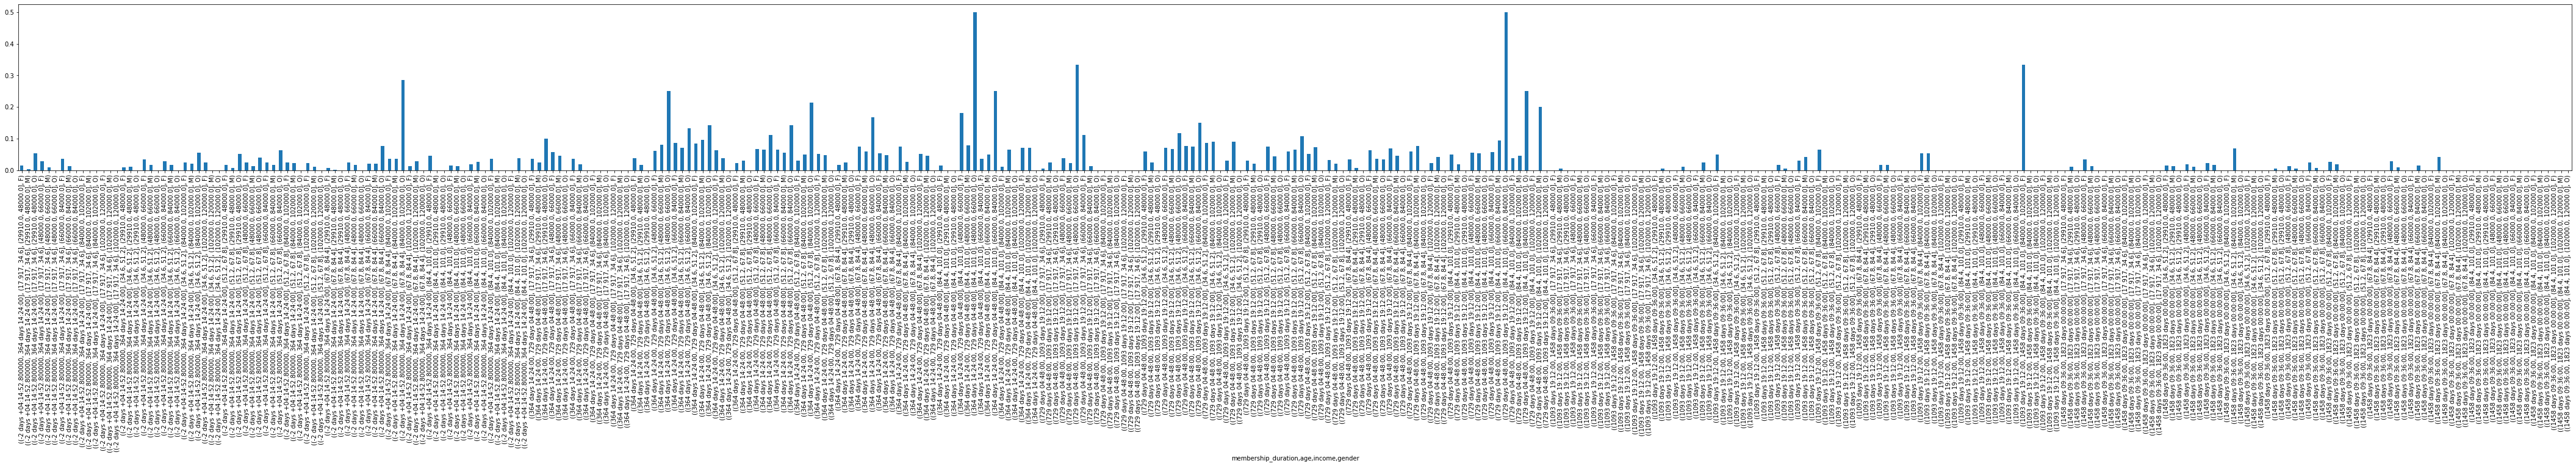

In [66]:
received_grouped_completion.plot.bar(figsize=(75,5));

In [67]:
received_grouped_count = received.groupby(
    [
        pd.cut(received['membership_duration'], bins=5), 
        pd.cut(received['age'], bins=5),
        pd.cut(received['income'], bins=5),
        "gender"
    ]
)["completed"].count()
hit_list = pd.DataFrame([received_grouped_completion, received_grouped_count], index=["completion", "count"]).T
hit_list

completion  \
membership_duration                           age            income               gender               
(-2 days +04:14:52.800000, 364 days 14:24:00] (17.917, 34.6] (29910.0, 48000.0]   F         0.015267   
                                                                                  M         0.003667   
                                                                                  O         0.052632   
                                                             (48000.0, 66000.0]   F         0.027460   
                                                                                  M         0.008123   
...                                                                                              ...   
(1458 days 09:36:00, 1823 days 00:00:00]      (84.4, 101.0]  (84000.0, 102000.0]  M         0.000000   
                                                                                  O              NaN   
                                                             (102000.0, 120000.0] F              NaN   
                                                                                  M              NaN   
                                                                                  O              NaN   

                                                                                           count  
membership_duration                           age            income               gender          
(-2 days +04:14:52.800000, 364 days 14:24:00] (17.917, 34.6] (29910.0, 48000.0]   F        524.0  
                                                                                  M       1636.0  
                                                                                  O         38.0  
                                                             (48000.0, 66000.0]   F        437.0  
                                                                                  M       1231.0  
...                                                                                          ...  
(1458 days 09:36:00, 1823 days 00:00:00]      (84.4, 101.0]  (84000.0, 102000.0]  M          4.0  
                                                                                  O          NaN  
                                                             (102000.0, 120000.0] F          NaN  
                                                                                  M          NaN  
                                                                                  O          NaN  

[375 rows x 2 columns]

In [68]:
hit_list[hit_list["count"] > 25].sort_values(by="completion", ascending=False)

completion  \
membership_duration                           age            income              gender               
(364 days 14:24:00, 729 days 04:48:00]        (84.4, 101.0]  (48000.0, 66000.0]  F         0.181818   
                                              (51.2, 67.8]   (48000.0, 66000.0]  O         0.111111   
(729 days 04:48:00, 1093 days 19:12:00]       (17.917, 34.6] (66000.0, 84000.0]  F         0.111111   
                                              (51.2, 67.8]   (66000.0, 84000.0]  O         0.107143   
(364 days 14:24:00, 729 days 04:48:00]        (34.6, 51.2]   (84000.0, 102000.0] M         0.096386   
...                                                                                             ...   
(1093 days 19:12:00, 1458 days 09:36:00]      (51.2, 67.8]   (84000.0, 102000.0] M         0.000000   
(-2 days +04:14:52.800000, 364 days 14:24:00] (67.8, 84.4]   (29910.0, 48000.0]  O         0.000000   
                                                             (48000.0, 66000.0]  O         0.000000   
(1093 days 19:12:00, 1458 days 09:36:00]      (51.2, 67.8]   (29910.0, 48000.0]  F         0.000000   
                                              (67.8, 84.4]   (29910.0, 48000.0]  M         0.000000   

                                                                                         count  
membership_duration                           age            income              gender         
(364 days 14:24:00, 729 days 04:48:00]        (84.4, 101.0]  (48000.0, 66000.0]  F        33.0  
                                              (51.2, 67.8]   (48000.0, 66000.0]  O        27.0  
(729 days 04:48:00, 1093 days 19:12:00]       (17.917, 34.6] (66000.0, 84000.0]  F        45.0  
                                              (51.2, 67.8]   (66000.0, 84000.0]  O        28.0  
(364 days 14:24:00, 729 days 04:48:00]        (34.6, 51.2]   (84000.0, 102000.0] M       166.0  
...                                                                                        ...  
(1093 days 19:12:00, 1458 days 09:36:00]      (51.2, 67.8]   (84000.0, 102000.0] M        56.0  
(-2 days +04:14:52.800000, 364 days 14:24:00] (67.8, 84.4]   (29910.0, 48000.0]  O        29.0  
                                                             (48000.0, 66000.0]  O        41.0  
(1093 days 19:12:00, 1458 days 09:36:00]      (51.2, 67.8]   (29910.0, 48000.0]  F        29.0  
                                              (67.8, 84.4]   (29910.0, 48000.0]  M        81.0  

[191 rows x 2 columns]

In [69]:
default_grouping = [
    pd.cut(received['membership_duration'], bins=5), 
    pd.cut(received['age'], bins=5),
    pd.cut(received['income'], bins=5),
    "gender"
]
def create_hit_list(received=received, grouping=default_grouping, min_members=25):
    """
    Create a list of groups, their completion rates and counts (ordered by completion rate).
    Args:
        - received (df): Dataframe of completed `offer received` events.
        - grouping (list): List of column names or `pd.cut` outputs for grouping
        - min_members (int): Minimal amount of users in this group. 
    """
    received_grouped_completion = received.groupby(grouping)["completed"].mean()
    received_grouped_count = received.groupby(grouping)["completed"].count()
    hit_list = pd.DataFrame([received_grouped_completion, received_grouped_count], index=["completion", "count"]).T
    return hit_list[hit_list["count"] > min_members].sort_values(by="completion", ascending=False)
    
create_hit_list()

completion  \
membership_duration                           age            income              gender               
(364 days 14:24:00, 729 days 04:48:00]        (84.4, 101.0]  (48000.0, 66000.0]  F         0.181818   
                                              (51.2, 67.8]   (48000.0, 66000.0]  O         0.111111   
(729 days 04:48:00, 1093 days 19:12:00]       (17.917, 34.6] (66000.0, 84000.0]  F         0.111111   
                                              (51.2, 67.8]   (66000.0, 84000.0]  O         0.107143   
(364 days 14:24:00, 729 days 04:48:00]        (34.6, 51.2]   (84000.0, 102000.0] M         0.096386   
...                                                                                             ...   
(1093 days 19:12:00, 1458 days 09:36:00]      (51.2, 67.8]   (84000.0, 102000.0] M         0.000000   
(-2 days +04:14:52.800000, 364 days 14:24:00] (67.8, 84.4]   (29910.0, 48000.0]  O         0.000000   
                                                             (48000.0, 66000.0]  O         0.000000   
(1093 days 19:12:00, 1458 days 09:36:00]      (51.2, 67.8]   (29910.0, 48000.0]  F         0.000000   
                                              (67.8, 84.4]   (29910.0, 48000.0]  M         0.000000   

                                                                                         count  
membership_duration                           age            income              gender         
(364 days 14:24:00, 729 days 04:48:00]        (84.4, 101.0]  (48000.0, 66000.0]  F        33.0  
                                              (51.2, 67.8]   (48000.0, 66000.0]  O        27.0  
(729 days 04:48:00, 1093 days 19:12:00]       (17.917, 34.6] (66000.0, 84000.0]  F        45.0  
                                              (51.2, 67.8]   (66000.0, 84000.0]  O        28.0  
(364 days 14:24:00, 729 days 04:48:00]        (34.6, 51.2]   (84000.0, 102000.0] M       166.0  
...                                                                                        ...  
(1093 days 19:12:00, 1458 days 09:36:00]      (51.2, 67.8]   (84000.0, 102000.0] M        56.0  
(-2 days +04:14:52.800000, 364 days 14:24:00] (67.8, 84.4]   (29910.0, 48000.0]  O        29.0  
                                                             (48000.0, 66000.0]  O        41.0  
(1093 days 19:12:00, 1458 days 09:36:00]      (51.2, 67.8]   (29910.0, 48000.0]  F        29.0  
                                              (67.8, 84.4]   (29910.0, 48000.0]  M        81.0  

[191 rows x 2 columns]

### Which one has a higher response rage? BOGO or Discount? Differences in gender?

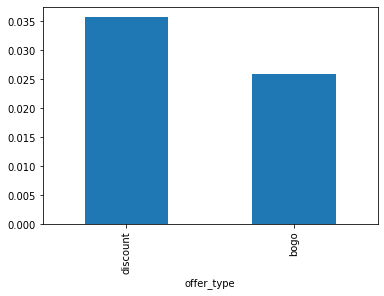

In [70]:
create_hit_list(grouping=["offer_type"])["completion"].T.plot.bar();

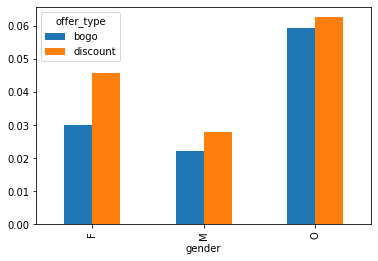

In [71]:
create_hit_list(grouping=["offer_type", "gender"]).unstack()["completion"].T.plot.bar();

> Seems like males are not so responding.

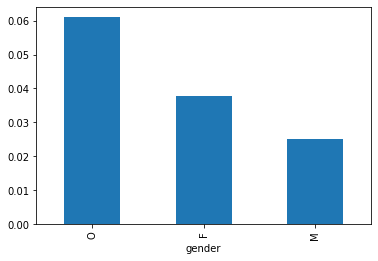

In [72]:
create_hit_list(grouping=["gender"]).unstack()["completion"].T.plot.bar();

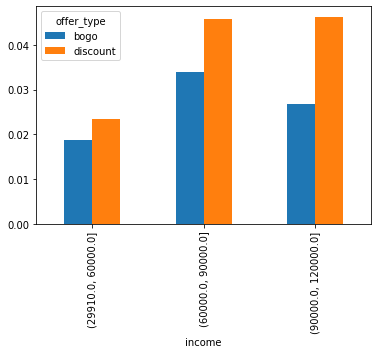

In [73]:
create_hit_list(grouping=["offer_type", pd.cut(received['income'], bins=3)]).unstack()["completion"].T.plot.bar();

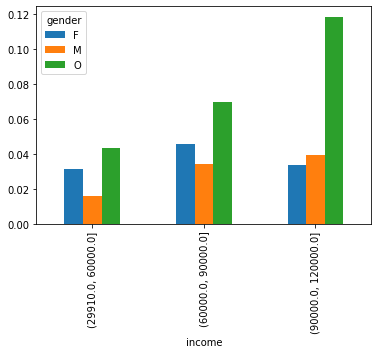

In [74]:
create_hit_list(grouping=["gender", pd.cut(received['income'], bins=3)]).unstack()["completion"].T.plot.bar();

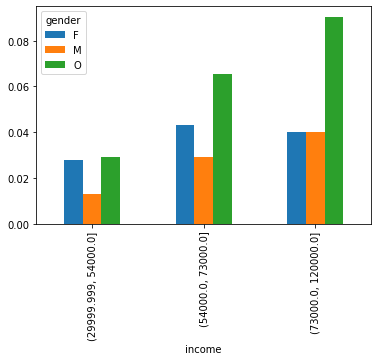

In [75]:
create_hit_list(grouping=["gender", pd.qcut(received['income'], q=3)]).unstack()["completion"].T.plot.bar();

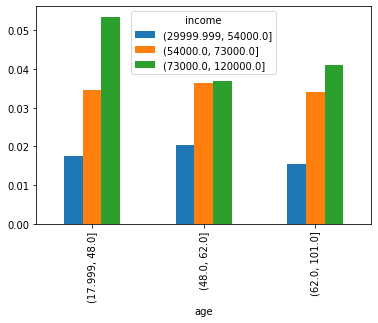

In [76]:
df = create_hit_list(grouping=[
    pd.qcut(received['age'], q=3), 
    pd.qcut(received['income'], q=3)
])["completion"].T.unstack()
df.columns = df.columns.astype(str)
df.plot.bar();

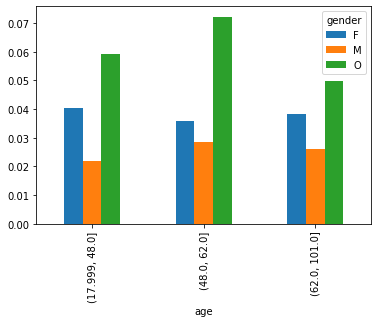

In [77]:
create_hit_list(grouping=["gender", pd.qcut(received['age'], q=3)]).unstack()["completion"].T.plot.bar();

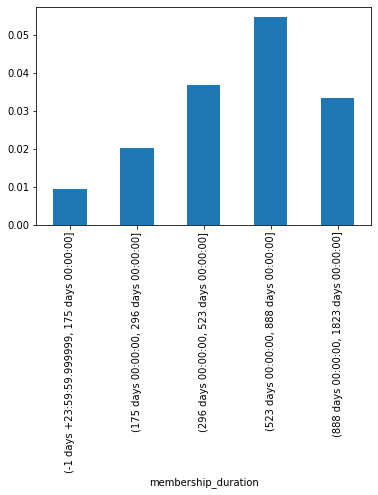

In [78]:
create_hit_list(grouping=[pd.qcut(received['membership_duration'], q=5)]).unstack()["completion"].sort_index().plot.bar();

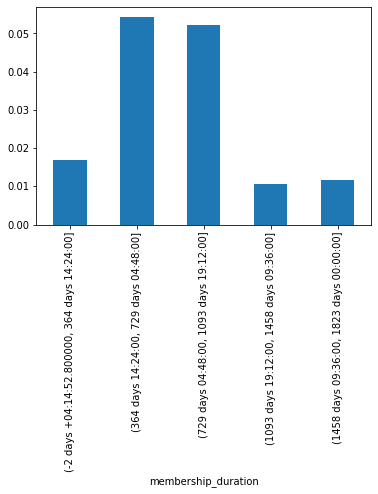

In [79]:
create_hit_list(grouping=[pd.cut(received['membership_duration'], bins=5)]).unstack()["completion"].sort_index().plot.bar();

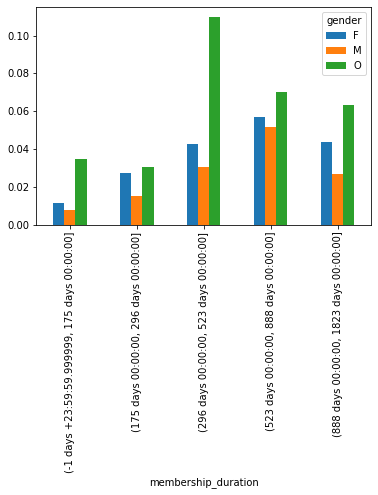

In [80]:
create_hit_list(grouping=[
    "gender",
    pd.qcut(received['membership_duration'], q=5)
]).unstack()["completion"].T.sort_index().plot.bar();

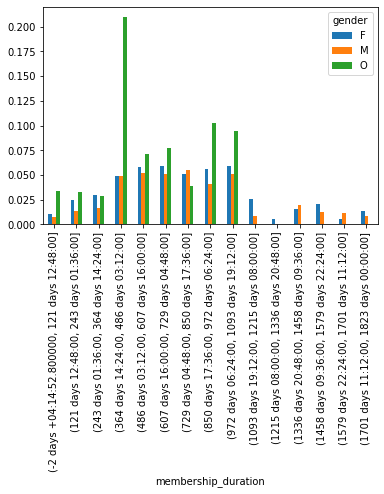

In [81]:
create_hit_list(grouping=[
    "gender",
    pd.cut(received['membership_duration'], bins=15)
]).unstack()["completion"].T.sort_index().plot.bar();

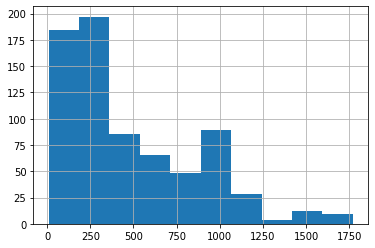

In [82]:
received[received["gender"] == "O"]["membership_duration"].dt.days.hist();

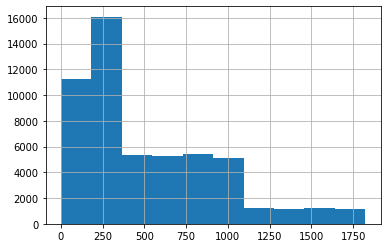

In [83]:
received["membership_duration"].dt.days.hist();

### Histograms, Means and Standard Deviations 

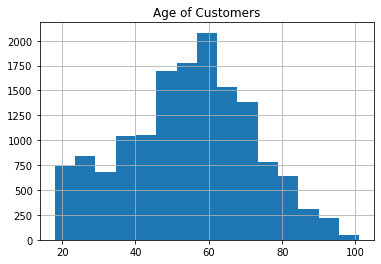

In [84]:
profile["age"].hist(bins=15);
plt.title("Age of Customers");

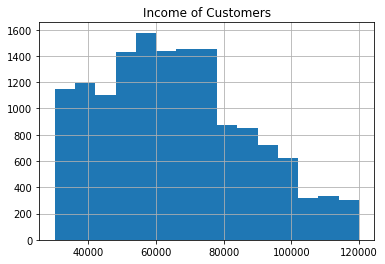

In [85]:
profile["income"].hist(bins=15);
plt.title("Income of Customers");

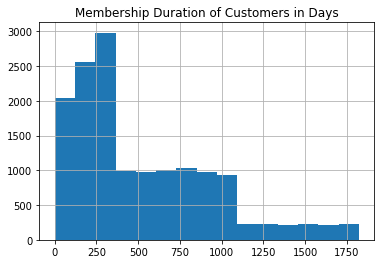

In [86]:
profile["membership_duration"].hist(bins=15);
plt.title("Membership Duration of Customers in Days");

In [87]:
profile[["membership_duration", "age", "income"]].describe()

,membership_duration,age,income
count,14825.000000,14825.000000,14825.000000
mean,522.478988,54.393524,65404.991568
std,419.205158,17.383705,21598.299410
min,0.000000,18.000000,30000.000000
25%,208.000000,42.000000,49000.000000
50%,358.000000,55.000000,64000.000000
75%,797.000000,66.000000,80000.000000
max,1823.000000,101.000000,120000.000000


### Which channel for which user?

In [88]:
for channel in ["web", "email", "mobile", "social"]:
    received[channel] = received["channels"].apply(lambda x: channel in x)
received.head()

,person,event,value,time,offer_id,completed,viewed,reward,channels,difficulty,...,gender,age,id_profile,became_member_on,income,membership_duration,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,True,5,"[web, email, mobile]",5,...,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,443 days,True,True,True,False
1,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},504,f19421c1d4aa40978ebb69ca19b0e20d,0,False,5,"[web, email, mobile, social]",5,...,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,443 days,True,True,True,True
2,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408,ae264e3637204a6fb9bb56bc8210ddfd,0,True,10,"[email, mobile, social]",10,...,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,443 days,False,True,True,True
3,ebe7ef46ea6f4963a7dd49f501b26779,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,False,5,"[web, email, mobile]",5,...,M,59,ebe7ef46ea6f4963a7dd49f501b26779,20150121,41000.0,1282 days,True,True,True,False
4,ebe7ef46ea6f4963a7dd49f501b26779,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},576,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,False,5,"[web, email, mobile]",5,...,M,59,ebe7ef46ea6f4963a7dd49f501b26779,20150121,41000.0,1282 days,True,True,True,False


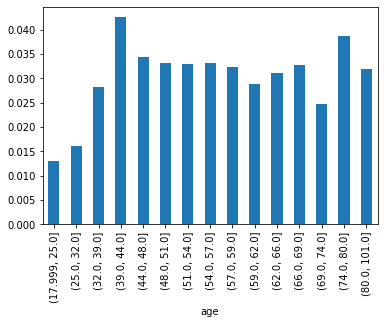

In [89]:
create_hit_list(received=received[received["web"]==True],
    grouping=[
        pd.qcut(received[received["web"]==True]['age'], q=15)
    ]
).unstack()["completion"].T.sort_index().plot.bar();

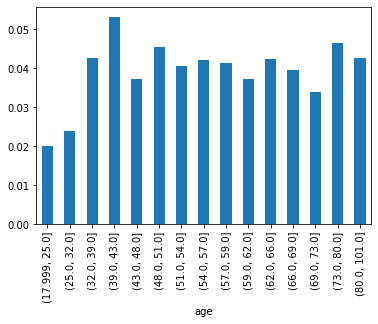

In [90]:
create_hit_list(received=received[received["social"]==True],
    grouping=[
        pd.qcut(received[received["social"]==True]['age'], q=15)
    ]
).unstack()["completion"].T.sort_index().plot.bar();

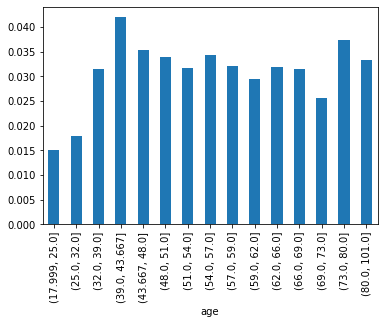

In [91]:
create_hit_list(received=received[received["email"]==True],
    grouping=[
        pd.qcut(received[received["email"]==True]['age'], q=15)
    ]
).unstack()["completion"].T.sort_index().plot.bar();

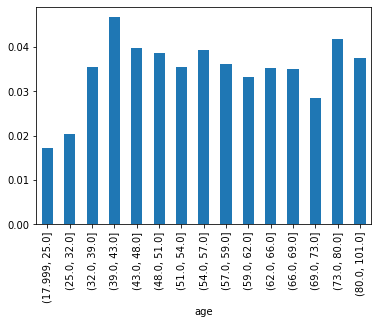

In [92]:
create_hit_list(received=received[received["mobile"]==True],
    grouping=[
        pd.qcut(received[received["mobile"]==True]['age'], q=15)
    ]
).unstack()["completion"].T.sort_index().plot.bar();

> There is no indication, that there is correlation between a channel and a response rate. 

### Which group responds to informational offers

In [93]:
portfolio[portfolio["offer_type"] == "informational"]

,reward,channels,difficulty,duration,offer_type,id
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


In [94]:
info_offer_received = transcript[transcript["event"] == "offer received"]
info_offer_received.index.name = "event_id"
info_offer_received = info_offer_received[["offer_id", "time", "person"]].reset_index().merge(
    portfolio[portfolio["offer_type"] == "informational"][["id", "duration"]], 
    how='inner', 
    left_on="offer_id", 
    right_on="id"
)
info_offer_received["max_end_time"] = offer_received[["time", "duration"]].sum(axis=1)
info_offer_received.head()

,event_id,offer_id,time,person,id,duration,max_end_time
0,7,3f207df678b143eea3cee63160fa8bed,0,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,4,7
1,13,3f207df678b143eea3cee63160fa8bed,0,c27e0d6ab72c455a8bb66d980963de60,3f207df678b143eea3cee63160fa8bed,4,7
2,56,3f207df678b143eea3cee63160fa8bed,0,2c5c63e5124e417b8504f76c868a4190,3f207df678b143eea3cee63160fa8bed,4,7
3,76,3f207df678b143eea3cee63160fa8bed,0,5e9c83e8ab4d4e9ca83f3256d83ca756,3f207df678b143eea3cee63160fa8bed,4,7
4,90,3f207df678b143eea3cee63160fa8bed,0,6747dda08bed46298c23e05b64820a3a,3f207df678b143eea3cee63160fa8bed,4,7


In [95]:
# joining "offer received" and "transaction" to check them afterwards
info_received_transcript = info_offer_received.merge(
    transcript[transcript["event"] == "transaction"],
    how="left",
    on="person",
    suffixes=["_received", "_responded"]
).drop(columns=["duration", "id", "value", "event"])
info_received_transcript.head()

,event_id,offer_id_received,time_received,person,max_end_time,time_responded,offer_id_responded,completed,viewed
0,7,3f207df678b143eea3cee63160fa8bed,0,2eeac8d8feae4a8cad5a6af0499a211d,7,216.0,NaN,NaN,NaN
1,7,3f207df678b143eea3cee63160fa8bed,0,2eeac8d8feae4a8cad5a6af0499a211d,7,378.0,NaN,NaN,NaN
2,7,3f207df678b143eea3cee63160fa8bed,0,2eeac8d8feae4a8cad5a6af0499a211d,7,456.0,NaN,NaN,NaN
3,7,3f207df678b143eea3cee63160fa8bed,0,2eeac8d8feae4a8cad5a6af0499a211d,7,570.0,NaN,NaN,NaN
4,13,3f207df678b143eea3cee63160fa8bed,0,c27e0d6ab72c455a8bb66d980963de60,7,18.0,NaN,NaN,NaN


In [96]:
(
    (info_received_transcript["time_responded"] >= info_received_transcript["time_received"]) &
    (info_received_transcript["time_responded"] <= info_received_transcript["max_end_time"]) 
).sum()

2397

In [97]:
# check which offers have actually been viewed
info_received_transcript["responses"] = (
    (info_received_transcript["time_responded"] >= info_received_transcript["time_received"]) &
    (info_received_transcript["time_responded"] <= info_received_transcript["max_end_time"]) 
).astype(int)
response = info_received_transcript.groupby("event_id")["responses"].sum()

transcript["response"] = response
transcript.loc[response.index, "completed"] = ((response > 0) & (transcript.loc[response.index, "viewed"]))
received["response"] = response

In [98]:
transcript[transcript["event"]=="offer received"].merge(
    portfolio[portfolio["offer_type"]=="informational"], 
    left_on="offer_id", 
    right_on="id"
)[["response"]].sum()

response    2397.0
dtype: float64

In [99]:
transcript[transcript["event"]=="offer received"].merge(
    portfolio[portfolio["offer_type"]=="informational"], 
    left_on="offer_id", 
    right_on="id"
)[["response"]].max()

response    20.0
dtype: float64

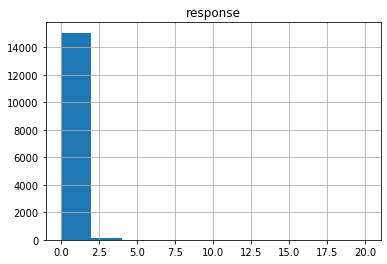

In [100]:
transcript[transcript["event"]=="offer received"].merge(
    portfolio[portfolio["offer_type"]=="informational"], 
    left_on="offer_id", 
    right_on="id"
)[["response"]].hist();

In [101]:
info_received = transcript[transcript["event"]=="offer received"].merge(
    portfolio[portfolio["offer_type"]=="informational"], 
    left_on="offer_id", 
    right_on="id"
).merge(
    profile,
    left_on="person",
    right_on="id"
)
info_received.head()

,person,event,value,time,offer_id,completed,viewed,response,reward,channels,difficulty,duration,offer_type,id_x,gender,age,id_y,became_member_on,income,membership_duration
0,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,False,False,0.0,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,257
1,c27e0d6ab72c455a8bb66d980963de60,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,False,False,0.0,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,F,78,c27e0d6ab72c455a8bb66d980963de60,20170616,71000.0,405
2,c27e0d6ab72c455a8bb66d980963de60,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,3f207df678b143eea3cee63160fa8bed,False,False,0.0,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,F,78,c27e0d6ab72c455a8bb66d980963de60,20170616,71000.0,405
3,c27e0d6ab72c455a8bb66d980963de60,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837,False,False,0.0,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,F,78,c27e0d6ab72c455a8bb66d980963de60,20170616,71000.0,405
4,c27e0d6ab72c455a8bb66d980963de60,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},576,5a8bc65990b245e5a138643cd4eb9837,False,False,0.0,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,F,78,c27e0d6ab72c455a8bb66d980963de60,20170616,71000.0,405


In [102]:
info_received.completed.mean()

0.03172932330827068

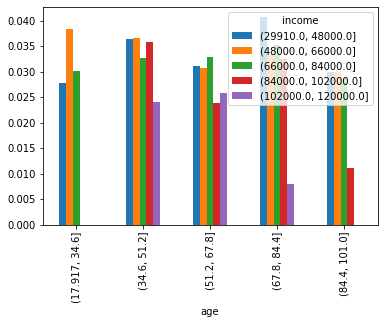

In [103]:
grouping = [
    pd.cut(info_received['age'], bins=5),
    pd.cut(info_received['income'], bins=5)
]
info_grouped_mean = info_received["completed"].astype(int).groupby(grouping).mean()
info_grouped_count = info_received["completed"].astype(int).groupby(grouping).count()
hit_list = pd.DataFrame([info_grouped_mean, info_grouped_count], index=["completion", "count"]).T
selected_hit_list = hit_list[hit_list["count"] > 5]["completion"].unstack()
selected_hit_list.columns = selected_hit_list.columns.astype(str)
selected_hit_list.plot.bar();

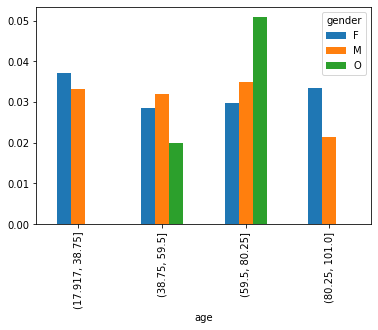

In [104]:
grouping = [
    pd.cut(info_received['age'], bins=4),
    info_received["gender"]
]
info_grouped_mean = info_received["completed"].astype(int).groupby(grouping).mean()
info_grouped_count = info_received["completed"].astype(int).groupby(grouping).count()
hit_list = pd.DataFrame([info_grouped_mean, info_grouped_count], index=["completion", "count"]).T
selected_hit_list = hit_list["completion"].unstack()
selected_hit_list.columns = selected_hit_list.columns.astype(str)
selected_hit_list.plot.bar();

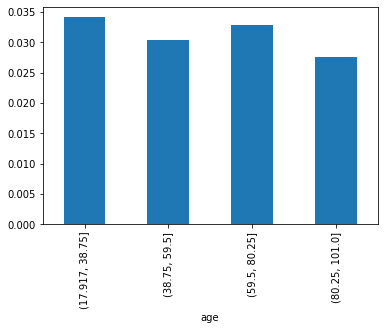

In [105]:
grouping = [
    pd.cut(info_received['age'], bins=4)
]
info_grouped_mean = info_received["completed"].astype(int).groupby(grouping).mean()
info_grouped_count = info_received["completed"].astype(int).groupby(grouping).count()
hit_list = pd.DataFrame([info_grouped_mean, info_grouped_count], index=["completion", "count"]).T
selected_hit_list = hit_list["completion"]
selected_hit_list.plot.bar();

### Combine: Which demographic groups respond best to which offer type?

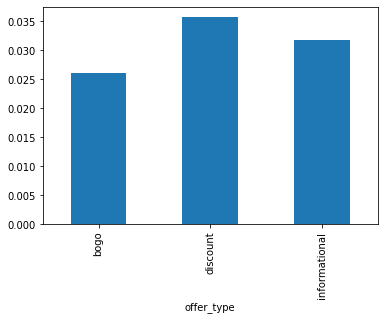

In [106]:
all_received = transcript[transcript["event"]=="offer received"].merge(
    portfolio, 
    left_on="offer_id", 
    right_on="id"
).merge(
    profile,
    left_on="person",
    right_on="id"
)
all_received["completed"] = all_received[["completed", "viewed"]].all(axis=1)
all_received["completed"].astype(int).groupby(all_received["offer_type"]).mean().plot.bar();

In [107]:
all_received[["completed", "income", "membership_duration", "age"]].corr()

,completed,income,membership_duration,age
completed,1.000000,0.035921,0.042084,0.013782
income,0.035921,1.000000,0.022914,0.305156
membership_duration,0.042084,0.022914,1.000000,0.008904
age,0.013782,0.305156,0.008904,1.000000


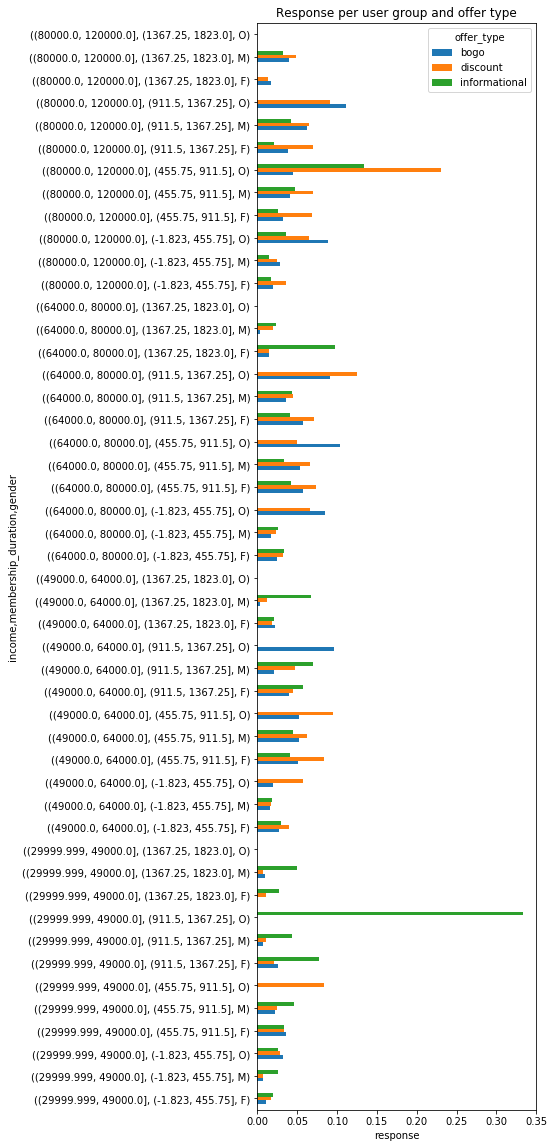

In [108]:
grouped_all_received = all_received["completed"].astype(int).groupby([
    pd.qcut(all_received['income'], q=4),
    pd.cut(all_received['membership_duration'], bins=4),
    all_received["gender"],    
    all_received["offer_type"]
]).mean()
grouped_all_received.unstack().plot.barh(figsize=(5,20));
plt.xlabel("response")
plt.title("Response per user group and offer type");

In [109]:
best_response = grouped_all_received.T.reset_index().set_index("offer_type").groupby(["income", "membership_duration", "gender"]).idxmax()
best_response["completed"]

income                membership_duration  gender
(29999.999, 49000.0]  (-1.823, 455.75]     F         informational
                                           M         informational
                                           O                  bogo
                      (455.75, 911.5]      F                  bogo
                                           M         informational
                                           O              discount
                      (911.5, 1367.25]     F         informational
                                           M         informational
                                           O         informational
                      (1367.25, 1823.0]    F         informational
                                           M         informational
                                           O                  bogo
(49000.0, 64000.0]    (-1.823, 455.75]     F              discount
                                           M         informational
            

In [110]:
best_response.reset_index()["completed"].value_counts()/best_response.shape[0]

discount         0.375000
informational    0.333333
bogo             0.291667
Name: completed, dtype: float64

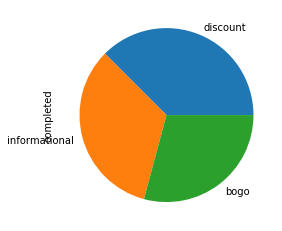

In [111]:
best_response.reset_index()["completed"].value_counts().plot.pie();

> Similar proportions of preferred offers for each group.

In [112]:
all_received.groupby([
    pd.cut(all_received['membership_duration'], bins=4),
    pd.qcut(all_received['income'], q=4),
    "gender"
])["completed"].count()

membership_duration  income                gender
(-1.823, 455.75]     (29999.999, 49000.0]  F         2831
                                           M         7570
                                           O          171
                     (49000.0, 64000.0]    F         3401
                                           M         6297
                                           O          163
                     (64000.0, 80000.0]    F         3959
                                           M         5055
                                           O          117
                     (80000.0, 120000.0]   F         4494
                                           M         3235
                                           O          119
(455.75, 911.5]      (29999.999, 49000.0]  F         1220
                                           M         1955
                                           O           31
                     (49000.0, 64000.0]    F         1769
                      

### Which group responds the most to which offer

In [113]:
grouped_all_received.T.reset_index().set_index(["membership_duration", "income", "gender"]).groupby("offer_type").idxmax()

,completed
offer_type,
bogo,"((911.5, 1367.25], (80000.0, 120000.0], O)"
discount,"((455.75, 911.5], (80000.0, 120000.0], O)"
informational,"((911.5, 1367.25], (29999.999, 49000.0], O)"


> These are fringe groups with 25 `((911.5, 1367.25], (80000.0, 120000.0], O)`, 50 `((455.75, 911.5], (80000.0, 120000.0], O)` or 14 `((911.5, 1367.25], (29999.999, 49000.0], O)` people

### Which channel should be used for which offer type?

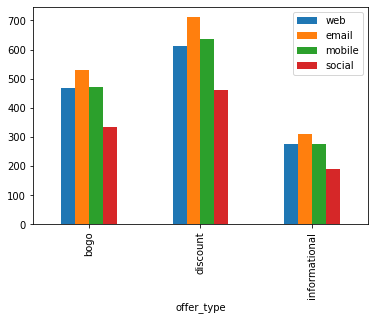

In [114]:
for channel in ["web", "email", "mobile", "social"]:
    all_received[channel] = received["channels"].apply(lambda x: channel in x)
all_received[all_received["completed"]==True].groupby("offer_type")[["web", "email", "mobile", "social"]].sum().plot.bar();

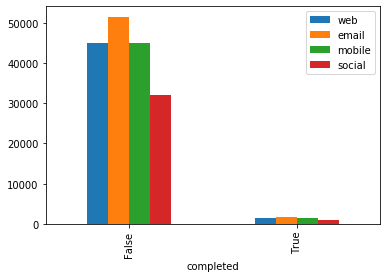

In [115]:
all_received.groupby("completed")[["web", "email", "mobile", "social"]].sum().plot.bar();

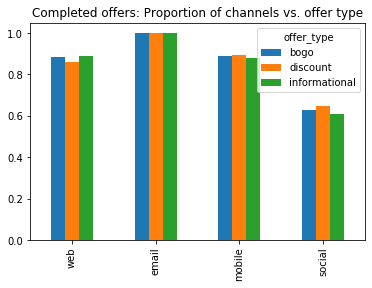

In [116]:
(
    all_received[all_received["completed"]==True].groupby("offer_type")[["web", "email", "mobile", "social"]].sum()
    /
    all_received[all_received["completed"]==True].groupby("offer_type")[["web", "email", "mobile", "social"]].count()
).T.plot.bar();
plt.title("Completed offers: Proportion of channels vs. offer type");

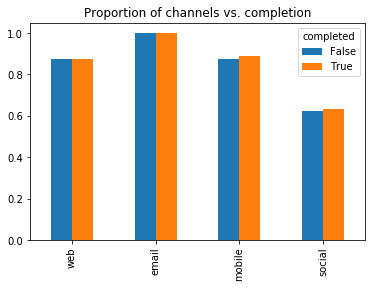

In [117]:
(
    all_received.groupby("completed")[["web", "email", "mobile", "social"]].sum()
    / 
    all_received.groupby("completed")[["web", "email", "mobile", "social"]].count()
).T.plot.bar();
plt.title("Proportion of channels vs. completion");

> There is no indication, that there is correlation between a channel and a response rate. 

## Predict: Can we predict the offer type with the highest response rate of a user?

In [118]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [119]:
y = all_received.groupby(["person","offer_type"])["offer_type"].count().groupby("person").idxmax().apply(lambda x: x[1])

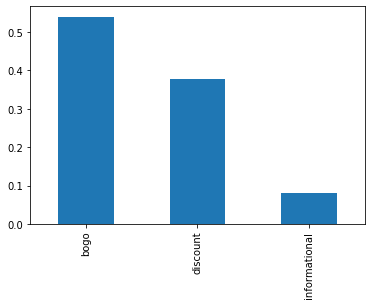

In [120]:
(y.value_counts()/y.shape[0]).plot.bar();

> Class imbalance detected.

In [121]:
# Note that 'ghosts' have been excluded earlier!
X = profile.set_index("id").loc[y.index]
X.head()

,gender,age,became_member_on,income,membership_duration
person,,,,,
0009655768c64bdeb2e877511632db8f,M,33,20170421,72000.0,461
0011e0d4e6b944f998e987f904e8c1e5,O,40,20180109,57000.0,198
0020c2b971eb4e9188eac86d93036a77,F,59,20160304,90000.0,874
0020ccbbb6d84e358d3414a3ff76cffd,F,24,20161111,60000.0,622
003d66b6608740288d6cc97a6903f4f0,F,26,20170621,73000.0,400


In [122]:
y = OneHotEncoder().fit_transform(y.values.reshape((y.shape[0], 1))).toarray()

In [123]:
X["gender"] = LabelEncoder().fit_transform(X["gender"])

In [124]:
X["became_member_on_year"] = (X["became_member_on"]/10000).astype(int)
X["became_member_on_month"] = ((X["became_member_on"]%10000)/100).astype(int)
X = X.drop(columns=["became_member_on"])

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [126]:
parameters = dict(
    n_estimators=[10, 50, 100, 200]
)
clf = GridSearchCV(RandomForestClassifier(), parameters, scoring="f1_weighted", n_jobs=3)

In [127]:
clf.fit(X_train, y_train)

/home/martin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

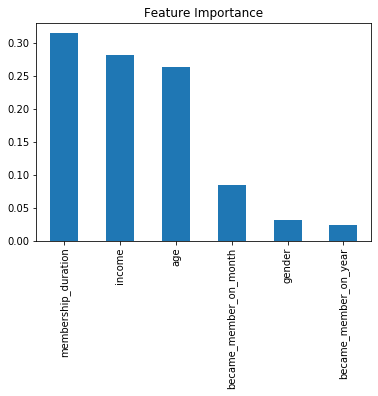

In [128]:
pd.Series(clf.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False).plot.bar();
plt.title("Feature Importance");

In [129]:
y_pred = clf.predict(X_test)

In [130]:
y_pred.sum(axis=0)

array([2163.,  809.,   17.])

In [131]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["bogo", "discount", "informational"]))

               precision    recall  f1-score   support

         bogo       0.54      0.59      0.56      1963
     discount       0.39      0.22      0.28      1430
informational       0.06      0.00      0.01       312

    micro avg       0.49      0.40      0.44      3705
    macro avg       0.33      0.27      0.28      3705
 weighted avg       0.44      0.40      0.41      3705
  samples avg       0.40      0.40      0.40      3705



/home/martin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


# Conclusion

For the given Starbucks dataset following questions have been examined:

##### Which channel should be used for which offer type?
We've seen no indication for correlation between a channel and a response rate. The used channel of a offer does not affect the response rate.

##### Can we predict the offer type with the highest response rate of a user?
Yes, we can! We've predicted the offer-type with the highest response rate for users. However, the model needs to be improved with additional features. Nevertheless, it's a great starting point for a recommendation system. A company can use such a classifier to predict the best fitting offer for a user.

### Further work
Response rates have been analyzed according to age, income, membership duration and gender of the customer. Given a user, with this information we know how similar users acted and can use this as prediction. However, let's say we want to send out an offer every week, then we would send only discounts for this user!
One important source of information should be analyzed and discovered: The time dimension. First of all, recommended offers should be relevant, but after this they should be also diverse.